FOR 5PSI_1:

Import all neccessary packages; create function to open and crop image simultaneously.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#scikit-image imports
import skimage.util as skutil
import skimage.io as io
import skimage.exposure as expo
from skimage.filters import threshold_otsu
from skimage import img_as_int #to convert to 8-bit uint
#Open/Crop Image
def openimage(image):
    I8 = io.imread(image).astype(np.float32)
#    I8 = img_as_ubyte(io.imread(image)) #Image as UINT8
    return I8[1:4380, 1:6250] #Crop Image [1 1 6250 4380]
    #imwrite(I8, '01-18 Original_Cropped.tif', 'compression', 'none')


Collect original image, use function to produce cropped image from the correct path. This block of code rescales the intensities of the image and subtracts the image, preparing it for thresholding.

After subtraction, image is thresholded usinbg automatic Otsu method.

In [3]:
#Grab original image
cropped = openimage(os.path.join(os.path.abspath('..'), 'data', '5 psi Runs', '5psi_1.tiff'))

#Adjust Image with range of intensities
p1, p2 = np.percentile(cropped, (5, 99.994))
Iadj = expo.rescale_intensity(cropped, in_range=(p1,p2))

#Get Background Image
bgimg = openimage(os.path.join(os.path.abspath('..'), 'data', '5 psi Runs', '5psi baseline.tiff'))
p3, p4 = np.percentile(bgimg, (0,100))
bgadj = expo.rescale_intensity(bgimg, in_range = (p1,p2))

#Subtract Image and Invert
isubt = np.subtract(cropped, bgimg)

isubt = skutil.invert(isubt)

#Threshold Image
threshed = threshold_otsu(isubt)
binary = isubt > threshed

Shows Original Image, Adjusted Image, Background Image.

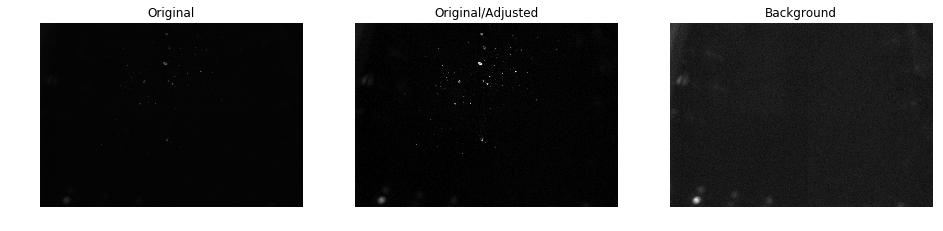

In [4]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 5))
ax = axes.ravel()
    
ax[0].imshow(cropped, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(Iadj, cmap=plt.cm.gray)
ax[1].set_title('Original/Adjusted')
ax[1].axis('off')
#    ax[1].hist(isubt.ravel(), bins=40)
#    ax[1].set_title('Histogram')
#    ax[1].axvline(threshed, color='r')
    
ax[2].imshow(bgimg,cmap=plt.cm.gray)
ax[2].set_title('Background')
ax[2].axis('off')

plt.show()

Subtracted and Thresholded Image produced.

Threshold value: -553.578125


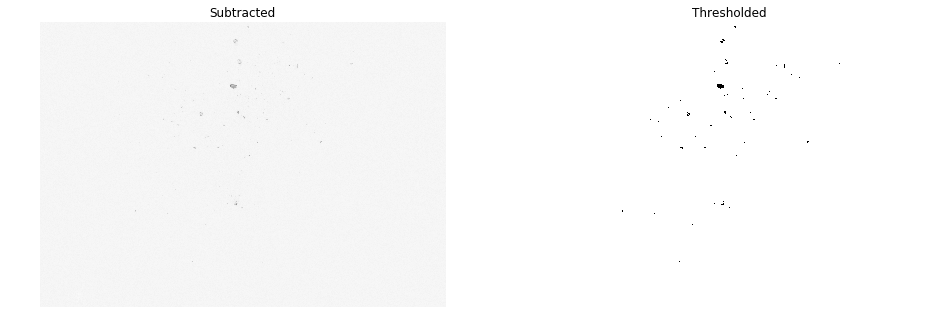

In [5]:
fig2, axes2 = plt.subplots(ncols=2, figsize=(16, 10))
ax2 = axes2.ravel()

ax2[0].imshow(isubt, cmap=plt.cm.gray)
ax2[0].set_title('Subtracted')
ax2[0].axis('off')

ax2[1].imshow(binary, cmap=plt.cm.gray)
ax2[1].set_title('Thresholded')
ax2[1].axis('off')
print('Threshold value: ' + str(threshed))
plt.show()

Interactive version of final thresholded image.

<IPython.core.display.Javascript object>


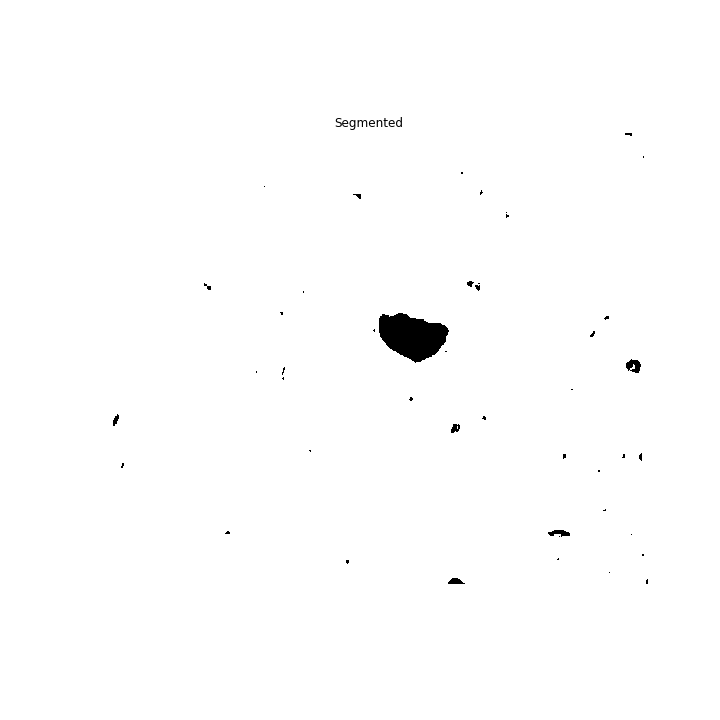

In [16]:
%matplotlib notebook
fig3, ax3 = plt.subplots(figsize=(10,10))

ax3.imshow(binary, cmap=plt.cm.gray)
ax3.set_title('Segmented')
ax3.axis('off') #Turns off axis for image

plt.show()

In [13]:
from skimage import img_as_ubyte
float_isubt = expo.rescale_intensity(isubt)
float_isubt = img_as_ubyte(float_isubt)

/home/james/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


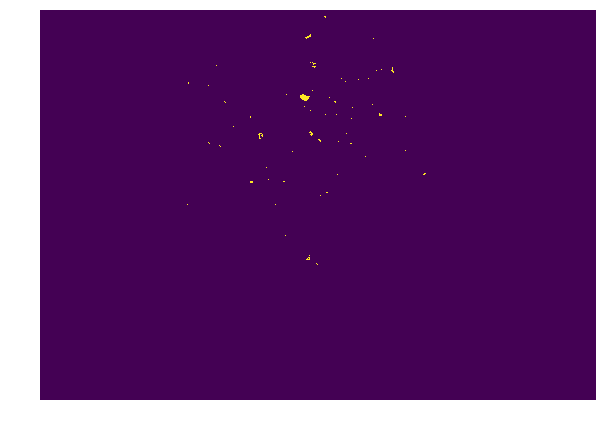

In [36]:
%matplotlib inline
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

bw = closing(isubt > threshed, square(3))
bw = skutil.invert(bw)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(bw)

ax.set_axis_off()
plt.tight_layout()
plt.show()

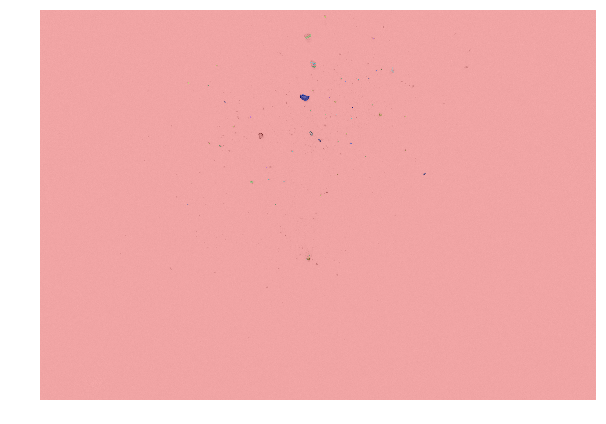

In [37]:
#cleared = clear_border(bw)
#ax.imshow(cleared)
label_image = label(bw)
image_label_overlay = label2rgb(label_image, image=float_isubt)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

ax.set_axis_off()
plt.tight_layout()
plt.show()

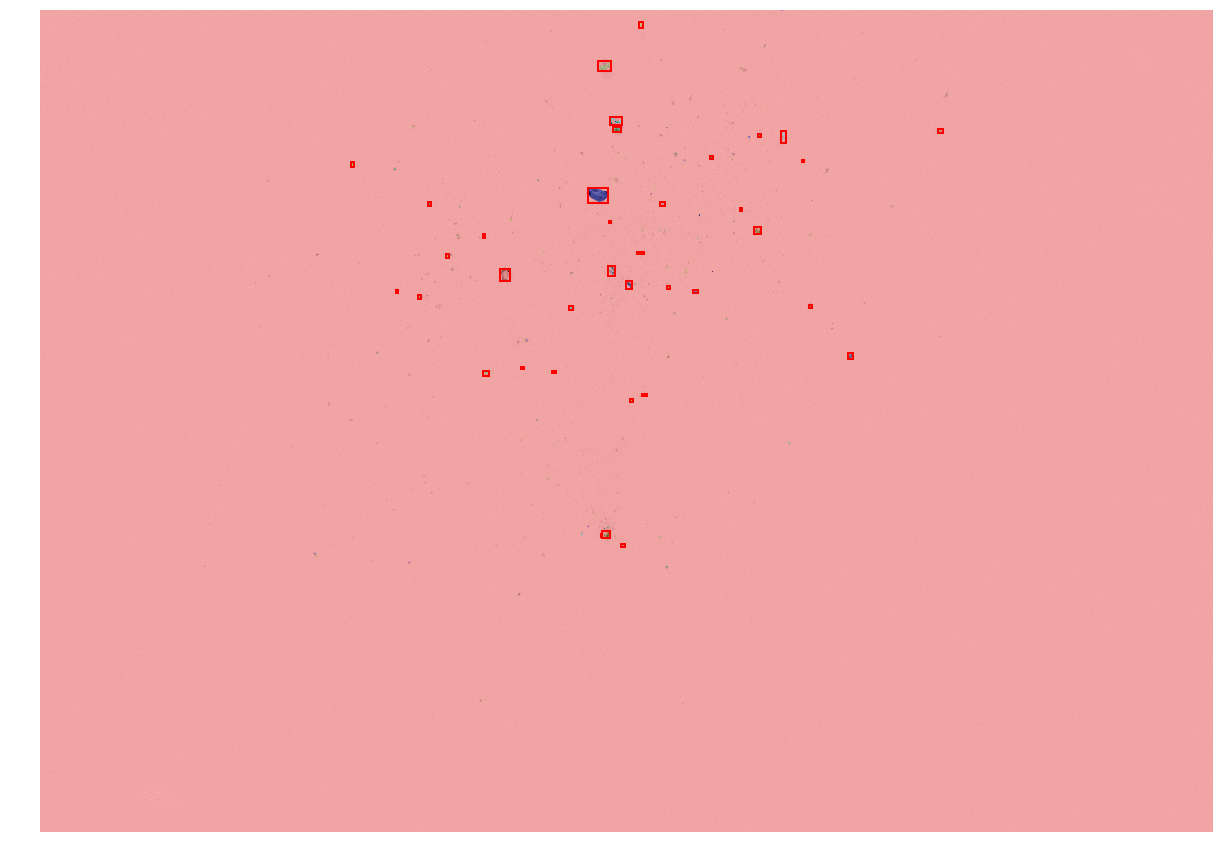

In [46]:
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(20, 12))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()